# Практика по NLP

Классификация по тональности и тематическое моделирование отзывов клиентов банков

Датасет: `banki_responses.json.bz2`

In [1]:
import json
import bz2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
tqdm.pandas()
import re

In [2]:
responses = []
with bz2.BZ2File('banki_responses.json.bz2', 'r') as hfile:
    for row in tqdm(hfile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [03:11, 1049.88it/s]


In [3]:
len(responses)

153499

In [4]:
responses[99]

{'city': 'г. Саратов',
 'rating_not_checked': False,
 'title': 'Карта ко вкладу',
 'num_comments': 0,
 'bank_license': 'лицензия № 880',
 'author': 'ronnichka',
 'bank_name': 'Югра',
 'datetime': '2015-06-03 20:56:57',
 'text': 'Здравствуйте! Хотела написать, что мне месяц не выдают карту ко вкладу, ссылаясь на "нам же их из Самары везут" (на секундочку 5 часов езды от нашего города). Но! Прочитала, что людям 3,5 месяцев не выдают карту, и поняла, что у меня все хорошо, пока что. И подарок мне дали, и кулер в отделении есть. Так что я, конечно, готова ждать. Правда хотелось бы не очень долго.',
 'rating_grade': 3}

---
Для удобства работы с данными преобразуем их в формат pandas

---

In [5]:
data = pd.DataFrame.from_dict(responses)
data.shape

(153499, 10)

In [6]:
data.head(3)

,author,bank_license,bank_name,city,datetime,num_comments,rating_grade,rating_not_checked,text,title
0,uhnov1,лицензия № 2562,Бинбанк,г. Москва,2015-06-08 12:50:54,0,NaN,False,Добрый день! Я не являюсь клиентом банка и пор...,Жалоба
1,Foryou,лицензия № 1481,Сбербанк России,г. Новосибирск,2015-06-08 11:09:57,0,NaN,False,Доброго дня! Являюсь держателем зарплатной кар...,Не могу пользоваться услугой Сбербанк он-лайн
2,Vladimir84,лицензия № 2562,Бинбанк,г. Москва,2015-06-05 20:14:28,1,NaN,False,Здравствуйте! Дублирую свое заявление от 03.0...,Двойное списание за один товар.


### Часть 1. Анализ текстов

1. Посчитайте количество отзывов в разных городах и на разные банки

In [7]:
# считаем число отзывов по городам
ratings_cities = data.groupby('city').size()
ratings_cities.sort_values(ascending=False)[:15]

city
г. Москва             55354
г. Санкт-Петербург    14342
г. Екатеринбург        2337
г. Новосибирск         2300
г. Нижний Новгород     1976
г. Ростов-на-Дону      1891
г. Самара              1731
г. Челябинск           1507
г. Казань              1440
г. Краснодар           1262
г. Уфа                 1246
г. Красноярск          1236
г. москва              1217
г. Воронеж             1210
г. Пермь               1163
dtype: int64

In [8]:
# считаем число отзывов на разные банки
ratings_banks = data.groupby('bank_name').size()
ratings_banks.sort_values(ascending=False)[:15]

bank_name
Сбербанк России              26327
Альфа-Банк                   10224
ВТБ 24                        8185
Русский Стандарт              7943
Хоум Кредит Банк              7549
Тинькофф Банк                 5387
Национальный Банк «Траст»     4607
Ренессанс Кредит              3849
Связной Банк                  3775
ОТП Банк                      3237
Восточный Экспресс Банк       3138
Райффайзенбанк                3057
Московский Кредитный Банк     2944
Ситибанк                      2848
Авангард                      2733
dtype: int64

2. Построить гистограммы длин слов в символах и в словах

*(тут наверное имеется в виду "длин **текстов** в символах и в словах")*

In [9]:
# считаем длины текстов в символах
data['text_len_sym'] = data.text.progress_apply(len)

100%|██████████████████████████████████████████████████████████████████████| 153499/153499 [00:00<00:00, 446473.18it/s]


In [10]:
data.head(3)

,author,bank_license,bank_name,city,datetime,num_comments,rating_grade,rating_not_checked,text,title,text_len_sym
0,uhnov1,лицензия № 2562,Бинбанк,г. Москва,2015-06-08 12:50:54,0,NaN,False,Добрый день! Я не являюсь клиентом банка и пор...,Жалоба,1523
1,Foryou,лицензия № 1481,Сбербанк России,г. Новосибирск,2015-06-08 11:09:57,0,NaN,False,Доброго дня! Являюсь держателем зарплатной кар...,Не могу пользоваться услугой Сбербанк он-лайн,1026
2,Vladimir84,лицензия № 2562,Бинбанк,г. Москва,2015-06-05 20:14:28,1,NaN,False,Здравствуйте! Дублирую свое заявление от 03.0...,Двойное списание за один товар.,588


In [11]:
# считаем длины текстов в словах
regex_tokenizer = re.compile("[А-Яа-яЁё]+")
def tokenize(text) -> str:
    return regex_tokenizer.findall(text)

In [12]:
data['text_len_words'] = data.text.progress_apply(tokenize).apply(len)

100%|████████████████████████████████████████████████████████████████████████| 153499/153499 [00:57<00:00, 2691.20it/s]


In [13]:
data.head(3)

,author,bank_license,bank_name,city,datetime,num_comments,rating_grade,rating_not_checked,text,title,text_len_sym,text_len_words
0,uhnov1,лицензия № 2562,Бинбанк,г. Москва,2015-06-08 12:50:54,0,NaN,False,Добрый день! Я не являюсь клиентом банка и пор...,Жалоба,1523,213
1,Foryou,лицензия № 1481,Сбербанк России,г. Новосибирск,2015-06-08 11:09:57,0,NaN,False,Доброго дня! Являюсь держателем зарплатной кар...,Не могу пользоваться услугой Сбербанк он-лайн,1026,135
2,Vladimir84,лицензия № 2562,Бинбанк,г. Москва,2015-06-05 20:14:28,1,NaN,False,Здравствуйте! Дублирую свое заявление от 03.0...,Двойное списание за один товар.,588,83


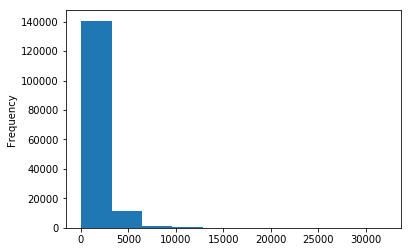

In [14]:
data.text_len_sym.plot.hist()

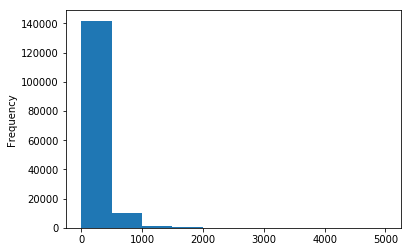

In [15]:
data.text_len_words.plot.hist()

3, 4. Найти 10 самых частых: 

    слов, слов без стоп-слов, лемм, существительных

In [16]:
# находим 10 самых частых слов
data.iloc[0].text

'Добрый день! Я не являюсь клиентом банка и поручителем по кредитному договору, а также не являюсь каким-либо другим лицом, письменно  оформившим отношения с банком по поводу урегулирования чьей-либо  задолженности.  Начиная с марта 2015 года начали приходить бесконечные письма из ООО "Примо коллект"на мой адрес: город Москва, Уваровский переулок, дом 10, квартира 111, с угрозами о возбуждении уголовного дела в отношении гражданина Филиппова Эдуарда Владимировича, который уклоняется от уплаты взятых им кредитов: договор № 81014 от 20.10.2013 года и договор № 2464946 от 09.10.2014 года. Со всей ответственностью\xa0 хочу Вас заверить, что вышеуказанный гражданин, которого Вы разыскиваете, мне не знаком и никогда в моем адресе не был зарегистрирован. Каким образом Вы не удостоверившись в подлинности его документов оформили на его имя кредитный договор, мне по меньшей мере не понятно,\xa0 и почему по Вашей милости я должна переживать и бояться за себе и свое имущество. Письма доставляют мн

In [17]:
alltexts = data.text.str.cat(sep='\n\n')

In [18]:
len(alltexts)

238877105

In [19]:
# суммарный текст очень длинный, в целях быстродействия сократим его в 1000 раз
alltexts = alltexts[: int(len(alltexts) / 1000)]
len(alltexts)

238877

In [20]:
print(alltexts[:2000])

Добрый день! Я не являюсь клиентом банка и поручителем по кредитному договору, а также не являюсь каким-либо другим лицом, письменно  оформившим отношения с банком по поводу урегулирования чьей-либо  задолженности.  Начиная с марта 2015 года начали приходить бесконечные письма из ООО "Примо коллект"на мой адрес: город Москва, Уваровский переулок, дом 10, квартира 111, с угрозами о возбуждении уголовного дела в отношении гражданина Филиппова Эдуарда Владимировича, который уклоняется от уплаты взятых им кредитов: договор № 81014 от 20.10.2013 года и договор № 2464946 от 09.10.2014 года. Со всей ответственностью  хочу Вас заверить, что вышеуказанный гражданин, которого Вы разыскиваете, мне не знаком и никогда в моем адресе не был зарегистрирован. Каким образом Вы не удостоверившись в подлинности его документов оформили на его имя кредитный договор, мне по меньшей мере не понятно,  и почему по Вашей милости я должна переживать и бояться за себе и свое имущество. Письма доставляют мне серье

In [21]:
tokens = tokenize(alltexts)

In [22]:
len(tokens)

35034

In [24]:
tokens[:10]

['Добрый',
 'день',
 'Я',
 'не',
 'являюсь',
 'клиентом',
 'банка',
 'и',
 'поручителем',
 'по']

In [25]:
# 10 самых частых слов
from collections import Counter
Counter(tokens).most_common(10)

[('в', 1149),
 ('и', 974),
 ('не', 843),
 ('на', 645),
 ('что', 605),
 ('я', 467),
 ('с', 437),
 ('по', 342),
 ('мне', 295),
 ('банка', 252)]

In [26]:
# 10 самых частых слов без стоп-слов
from nltk.corpus import stopwords

mystopwords = stopwords.words('russian') + ['это', 'наш' , 'тыс', 'млн', 'млрд', 'также',  'т', 'д']
def remove_stopwords(tokens: list, stopwords: list) -> list:
    return [token for token in tokens if not token.lower() in stopwords]

tokens_no_stopwords = remove_stopwords(tokens, mystopwords)
len(tokens_no_stopwords)

21984

In [27]:
# 10 самых частых лемм
# используется ОС Windows, поэтому для лемматизации не применяем mystem из соображений скорости работы
from rnnmorph.predictor import RNNMorphPredictor
predictor = RNNMorphPredictor(language="ru")

def lemmatize(tokens: list) -> list:
    forms = predictor.predict(tokens)
    return [form.normal_form for form in forms]

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [28]:
lemmas = lemmatize(tokens)
Counter(lemmas).most_common(10)

[('в', 1325),
 ('я', 1148),
 ('и', 1038),
 ('не', 892),
 ('на', 716),
 ('банк', 689),
 ('что', 686),
 ('быть', 484),
 ('с', 470),
 ('он', 379)]

In [29]:
# 10 самых частых существительных
nouns = [form.word for form in predictor.predict(tokens) if form.pos == 'NOUN']
Counter(nouns).most_common(10)

[('банка', 252),
 ('банк', 179),
 ('карты', 116),
 ('деньги', 109),
 ('карту', 98),
 ('кредит', 89),
 ('года', 84),
 ('раз', 69),
 ('Банк', 69),
 ('банке', 69)]

5. Построить кривые Ципфа и Хипса

In [30]:
cnt = Counter()
n_tokens, n_types = [], []
for index, row in tqdm(data.iterrows(), total=len(data)):
    row_tokens = tokenize(row.text)
    cnt.update(row_tokens)
    n_types.append(len(cnt))
    n_tokens.append(sum(cnt.values()))

100%|█████████████████████████████████████████████████████████████████████████| 153499/153499 [13:32<00:00, 189.02it/s]


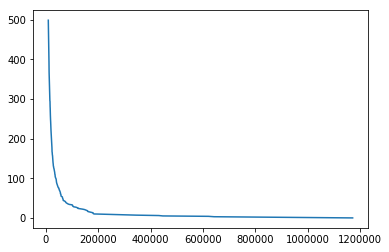

In [31]:
# кривая Ципфа
freqs = list(cnt.values())
freqs = sorted(freqs, reverse=True)
freqs_range = 500
plt.plot(freqs[:freqs_range], range(0, freqs_range))

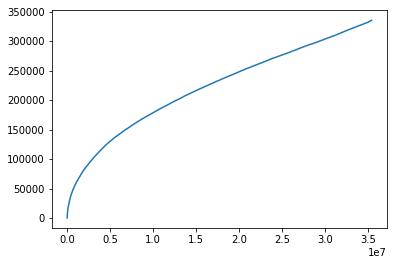

In [32]:
# кривая Хипса
plt.plot(n_tokens, n_types)

6. Ответьте на следующие вопросы:

    - какое слово встречается чаще, "сотрудник" или "клиент"
    - сколько раз встречаются слова "мошенничество" и "доверие"

In [33]:
print(f'Слово "сотрудник" встречается {cnt["сотрудник"]} раз')
print(f'Слово "клиент" встречается {cnt["клиент"]} раз')
print(f'Слово {"сотрудник" if cnt["сотрудник"] >= cnt["клиент"] else "клиент"} встречается чаще')

Слово "сотрудник" встречается 24693 раз
Слово "клиент" встречается 17561 раз
Слово сотрудник встречается чаще


In [34]:
print(f'Слово "мошенничество" встречается {cnt["мошенничество"]} раз')
print(f'Слово "доверие" встречается {cnt["доверие"]} раз')

Слово "мошенничество" встречается 976 раз
Слово "доверие" встречается 1025 раз


7. В поле rating_grade записана оценка от 1 до 5. 

    Использовать tf-idf, чтобы найти ключевые слова и биграммы для положительных отзывов (оценка 5) и отрицательных отзывов (оценка 1).

In [35]:
mystoplemmas = ['который','прошлый','сей', 'свой', 'наш', 'мочь', 'год']
def remove_stoplemmas(tokens):
    return [token for token in tokens if token not in mystoplemmas]

In [36]:
def preprocess_text(text) -> list:
    tokens = tokenize(text.lower())
    tokens_nostop = remove_stopwords(tokens, mystopwords)
    lemmas = lemmatize(tokens_nostop)
    return remove_stoplemmas(lemmas)

In [37]:
data.rating_grade.value_counts()

1.0    47387
5.0    14713
2.0    13509
3.0     9261
4.0     3788
Name: rating_grade, dtype: int64

In [38]:
# собираем тексты отрицательных отзывов
ratings_bad = data[data.rating_grade == 1]

In [39]:
# сделаем выборку, иначе очень долго считается
ratings_bad = ratings_bad.sample(n=int(len(ratings_bad) / 50))

In [40]:
tokens_bad = []
for i in tqdm(range(len(ratings_bad))):
    tokens_bad += preprocess_text(ratings_bad.text.iloc[i])

100%|████████████████████████████████████████████████████████████████████████████████| 947/947 [03:34<00:00,  6.79it/s]


In [41]:
len(tokens_bad)

149222

In [42]:
# собираем тексты положительных отзывов, аналогично делаем выборку
ratings_good = data[data.rating_grade == 5]
ratings_good = ratings_good.sample(n=int(len(ratings_good) / 50))

In [43]:
tokens_good = []
for i in tqdm(range(len(ratings_good))):
    tokens_good += preprocess_text(ratings_good.text.iloc[i])

100%|████████████████████████████████████████████████████████████████████████████████| 294/294 [00:53<00:00,  6.28it/s]


In [44]:
len(tokens_good)

39966

In [45]:
tokens_by_rating = [tokens_good, tokens_bad]

In [46]:
# tf-idf процедура, чтобы не повторять код
from sklearn.feature_extraction.text import TfidfVectorizer

def tfidf_rankings(tokens_grouped: list, group_id: int, num_words: int) -> pd.DataFrame:
    tfidf = TfidfVectorizer(analyzer='word', ngram_range=(num_words, num_words), min_df=0)
    tfidf_matrix = tfidf.fit_transform([' '.join(tokens) for tokens in tokens_grouped])
    feature_names = tfidf.get_feature_names() 
    tfidf_ranking = []
    dense = tfidf_matrix.todense()
    text = dense[group_id].tolist()[0]
    phrase_scores = [pair for pair in zip(range(0, len(text)), text) if pair[1] > 0]
    sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)
    phrases = []
    for phrase, score in [(feature_names[word_id], score) for (word_id, score) in sorted_phrase_scores][:40]:
        tfidf_ranking.append(phrase)
    return pd.DataFrame({'tf-idf': tfidf_ranking})

In [47]:
# ключевые слова для хороших отзывов
tfidf_rankings(tokens_by_rating, 0, 1).head(20)

,tf-idf
0,банк
1,карта
2,очень
3,день
4,кредит
5,отделение
6,клиент
7,деньга
8,вклад
9,банка


In [48]:
# ключевые слова для плохих отзывов
tfidf_rankings(tokens_by_rating, 1, 1).head(20)

,tf-idf
0,банк
1,карта
2,деньга
3,отделение
4,день
5,мой
6,счёт
7,кредит
8,сотрудник
9,клиент


In [49]:
# ключевые биграммы для хороших отзывов
tfidf_rankings(tokens_by_rating, 0, 2).head(20)

,tf-idf
0,сотрудник банк
1,интернет банк
2,кредитный карта
3,другой банка
4,следующий день
5,другой банк
6,дебетовый карта
7,клиент банк
8,открыть вклад
9,очень удобно


In [50]:
# ключевые биграммы для плохих отзывов
tfidf_rankings(tokens_by_rating, 1, 2).head(20)

,tf-idf
0,сотрудник банк
1,кредитный карта
2,отделение банк
3,денежный средство
4,горячий линия
5,написать заявление
6,отп банк
7,клиент банк
8,следующий день
9,альфа банк


### Часть 2. Тематическое моделирование

1. Постройте несколько тематических моделей коллекции документов с разным числом тем. Приведите примеры понятных (интерпретируемых) тем.
2. Найдите темы, в которых упомянуты конкретные банки. Можете ли вы их прокомментировать/объяснить?

In [51]:
data.head(2)

,author,bank_license,bank_name,city,datetime,num_comments,rating_grade,rating_not_checked,text,title,text_len_sym,text_len_words
0,uhnov1,лицензия № 2562,Бинбанк,г. Москва,2015-06-08 12:50:54,0,NaN,False,Добрый день! Я не являюсь клиентом банка и пор...,Жалоба,1523,213
1,Foryou,лицензия № 1481,Сбербанк России,г. Новосибирск,2015-06-08 11:09:57,0,NaN,False,Доброго дня! Являюсь держателем зарплатной кар...,Не могу пользоваться услугой Сбербанк он-лайн,1026,135


In [52]:
# делаем выборку данных, чтобы считалось быстрее
data_samples = data.sample(n=int(len(data)/100))

In [53]:
len(data_samples)

1534

In [54]:
texts = []

for i in tqdm(range(len(data_samples))):
     texts.append(preprocess_text(data_samples.iloc[i].text))

100%|██████████████████████████████████████████████████████████████████████████████| 1534/1534 [05:43<00:00,  4.46it/s]


In [55]:
len(texts)

1534

In [57]:
from gensim import corpora, models
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [58]:
# рассмотрим пять тем
lda = models.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=5)

In [59]:
lda.print_topics(num_words=20)

[(0,
  '0.023*"банк" + 0.016*"кредит" + 0.010*"мой" + 0.009*"день" + 0.008*"заявление" + 0.007*"карта" + 0.007*"кредитный" + 0.007*"договор" + 0.007*"сотрудник" + 0.007*"сумма" + 0.007*"рубль" + 0.006*"отделение" + 0.006*"сказать" + 0.006*"номер" + 0.005*"деньга" + 0.005*"банка" + 0.005*"вопрос" + 0.004*"сбербанк" + 0.004*"платёж" + 0.004*"звонить"'),
 (1,
  '0.026*"карта" + 0.025*"банк" + 0.015*"деньга" + 0.009*"день" + 0.009*"счёт" + 0.009*"заявление" + 0.008*"мой" + 0.007*"сумма" + 0.007*"отделение" + 0.007*"сказать" + 0.005*"сотрудник" + 0.005*"рубль" + 0.005*"операция" + 0.005*"банкомат" + 0.005*"платёж" + 0.004*"один" + 0.004*"такой" + 0.004*"позвонить" + 0.004*"время" + 0.004*"сбербанк"'),
 (2,
  '0.021*"банк" + 0.008*"день" + 0.007*"клиент" + 0.007*"счёт" + 0.007*"отделение" + 0.007*"сотрудник" + 0.006*"карта" + 0.006*"очередь" + 0.005*"банка" + 0.005*"мой" + 0.005*"кредит" + 0.005*"время" + 0.005*"вопрос" + 0.004*"офис" + 0.004*"деньга" + 0.004*"один" + 0.004*"работать" + 0.00

Попробуем интерпретировать полученные темы:
- 0. Вопросы предоставления кредитов (слова "кредит", "кредитный", "договор")
- 1. Внесение или вывод денежных средств по карте (слова "карта", "деньга", "сумма", "операция")
- 2. Задержки в обслуживании (слова "день", "отделение", "очередь", "время")
- 3. Задержки при работе с оформлением кредитов (слова "кредит", "день", "договор")
- 4. Вклады (слова "вклад", "счет", "деньга")

In [60]:
# рассмотрим 20 тем
lda = models.LdaModel(corpus, num_topics=20, id2word=dictionary, passes=5)

In [61]:
topics = lda.print_topics(num_words = 20)
topics

[(0,
  '0.012*"деньга" + 0.012*"банк" + 0.010*"день" + 0.009*"отделение" + 0.009*"счёт" + 0.007*"мой" + 0.007*"очередь" + 0.006*"клиент" + 0.005*"вклад" + 0.005*"один" + 0.005*"сотрудник" + 0.005*"заявление" + 0.004*"обслуживание" + 0.004*"депозит" + 0.004*"сумма" + 0.004*"время" + 0.004*"почему" + 0.003*"карта" + 0.003*"написать" + 0.003*"подпись"'),
 (1,
  '0.026*"банк" + 0.015*"кредит" + 0.009*"день" + 0.009*"договор" + 0.009*"сумма" + 0.009*"клиент" + 0.008*"счёт" + 0.008*"страхование" + 0.007*"мой" + 0.007*"сказать" + 0.007*"кредитный" + 0.007*"сотрудник" + 0.006*"страховой" + 0.006*"отделение" + 0.006*"банка" + 0.005*"рубль" + 0.005*"месяц" + 0.005*"один" + 0.004*"деньга" + 0.004*"такой"'),
 (2,
  '0.039*"карта" + 0.009*"номер" + 0.009*"банк" + 0.007*"сказать" + 0.006*"отделение" + 0.006*"прийти" + 0.006*"месяц" + 0.006*"счёт" + 0.005*"данные" + 0.005*"говорить" + 0.005*"день" + 0.005*"мой" + 0.005*"деньга" + 0.005*"телефон" + 0.005*"вопрос" + 0.005*"ответ" + 0.004*"срок" + 0.004

In [62]:
for topic in topics:
    if any(s in topic[1] for s in ['сбер', 'втб', 'альфа', 'открытие', 'гпб', 'рсхб', 'газпромбанк', 'бин', 'авангард']):
        print(topic)

(5, '0.019*"банк" + 0.016*"деньга" + 0.014*"карта" + 0.013*"рубль" + 0.009*"мой" + 0.009*"кредит" + 0.008*"сказать" + 0.007*"счёт" + 0.006*"оператор" + 0.006*"сбербанк" + 0.006*"звонить" + 0.006*"день" + 0.005*"телефон" + 0.005*"заявление" + 0.005*"платёж" + 0.005*"договор" + 0.005*"сумма" + 0.005*"проблема" + 0.004*"номер" + 0.004*"прийти"')
(6, '0.022*"банк" + 0.014*"деньга" + 0.011*"банкомат" + 0.009*"сотрудник" + 0.009*"отделение" + 0.007*"мой" + 0.007*"день" + 0.006*"офис" + 0.006*"сбербанк" + 0.006*"заявление" + 0.006*"рубль" + 0.005*"карта" + 0.005*"вклад" + 0.005*"банка" + 0.005*"счёт" + 0.005*"ситуация" + 0.005*"такой" + 0.005*"клиент" + 0.005*"работа" + 0.005*"говорить"')
(16, '0.032*"карта" + 0.021*"заявление" + 0.016*"банк" + 0.014*"сбербанк" + 0.013*"мой" + 0.013*"отделение" + 0.010*"день" + 0.010*"счёт" + 0.009*"средство" + 0.008*"деньга" + 0.006*"данный" + 0.006*"операция" + 0.006*"сотрудник" + 0.006*"ответ" + 0.005*"рубль" + 0.005*"денежный" + 0.005*"написать" + 0.005*"

Во всех перечисленных темах упомянут Сбербанк.
Рассмотрим эти темы (по номерам):
- 5. Вопросы по кредитным картам (слова "деньга", "карта", "рубль", "кредит").
- 6. Проблемы с вкладами (слова "деньга", "заявление", "рубль", "вклад", "ситуация").
- 16. Ввод-вывод денежных средств (слова "заявление", "мой", "счет", "средство", "деньга").

 ### Часть 3. Классификация текстов
 
 Решаем задачу бинарной классификации: различаем резко положительные отзывы (оценка 5) и резко отрицательные (оценка 1).

1. Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5. Используйте train_test_split для разделения множества отобранных документов на обучающее и тестовое.

In [63]:
# возьмем по 1500 положительных и отрицательных отзывов
data_good = data[data.rating_grade == 5].sample(n=1500)[['text', 'rating_grade']]
data_bad = data[data.rating_grade == 1].sample(n=1500)[['text', 'rating_grade']]
data_goodbad = pd.concat([data_good, data_bad])

In [64]:
data_goodbad.shape

(3000, 2)

In [65]:
data_goodbad.head()

,text,rating_grade
142814,Благодарю Начальника Управления по обслуживани...,5.0
74027,Недавно (31 августа) открыл депозит в Бинбанке...,5.0
146870,"Пользуюсь кредитной картой уже полгода, по про...",5.0
40936,Здравствуйте! Вас приветствует один из ваших V...,5.0
13173,"Добрый день, хотел поблагодарить сотрудников, ...",5.0


In [66]:
from sklearn.model_selection import train_test_split
x = data_goodbad.text
y = data_goodbad.rating_grade
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

2. Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline.
   
   Сравните разные варианты векторизации текста: использование только униграмм, пар или троек слов или с использованием символьных n-грамм.

In [67]:
def preprocess_dataset(dataset):
    return dataset.progress_apply(lambda x: ' '.join(preprocess_text(x)))

In [68]:
x_train_preprocessed = preprocess_dataset(x_train)

100%|██████████████████████████████████████████████████████████████████████████████| 2400/2400 [09:35<00:00,  4.54it/s]


In [69]:
x_test_preprocessed = preprocess_dataset(x_test)

100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [02:05<00:00,  6.54it/s]


In [70]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

clf_oneword = Pipeline([
    ('vect', CountVectorizer(analyzer='word', ngram_range=(1,1))),
    ('clf', MultinomialNB()),
])

In [71]:
clf_oneword.fit(x_train_preprocessed, y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [72]:
from sklearn.metrics import accuracy_score, f1_score
print("Униграммы")
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, clf_oneword.predict(x_test_preprocessed))))
print("F1-measure: {0:6.2f}".format(f1_score(y_test, clf_oneword.predict(x_test_preprocessed), average='macro')))

Униграммы
Accuracy:   0.89
F1-measure:   0.89


In [73]:
clf_twoword = Pipeline([
    ('vect', CountVectorizer(analyzer='word', ngram_range=(2,2))),
    ('clf', MultinomialNB()),
])
clf_twoword.fit(x_train_preprocessed, y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(2, 2), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [74]:
print('Биграммы')
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, clf_twoword.predict(x_test_preprocessed))))
print("F1-measure: {0:6.2f}".format(f1_score(y_test, clf_twoword.predict(x_test_preprocessed), average='macro')))

Биграммы
Accuracy:   0.89
F1-measure:   0.89


In [75]:
clf_threeword = Pipeline([
    ('vect', CountVectorizer(analyzer='word', ngram_range=(3,3))),
    ('clf', MultinomialNB()),
])
clf_threeword.fit(x_train_preprocessed, y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(3, 3), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [76]:
print('Триграммы')
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, clf_threeword.predict(x_test_preprocessed))))
print("F1-measure: {0:6.2f}".format(f1_score(y_test, clf_threeword.predict(x_test_preprocessed), average='macro')))

Триграммы
Accuracy:   0.77
F1-measure:   0.77


In [77]:
clf_nchar = Pipeline([
    ('vect', CountVectorizer(analyzer='char', ngram_range=(4,6))),
    ('clf', MultinomialNB()),
])
clf_nchar.fit(x_train_preprocessed, y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='char', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(4, 6), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [78]:
print('Символьные 4-6-граммы')
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, clf_nchar.predict(x_test_preprocessed))))
print("F1-measure: {0:6.2f}".format(f1_score(y_test, clf_nchar.predict(x_test_preprocessed), average='macro')))

Символьные 4-6-граммы
Accuracy:   0.88
F1-measure:   0.88


3. Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:
   
   1-й вариант: tf-idf преобразование и сингулярное разложение
   
   2-й вариант: тематические модели LDA

In [79]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier

clf_tfidf_svd = Pipeline([
    ('vect', CountVectorizer(analyzer='word', ngram_range=(2,2))),
    ('tfidf', TfidfTransformer()),
    ('tm', TruncatedSVD()),
    ('clf', RandomForestClassifier()), # используем Random Forest, так как Naive Bayes выдает ошибку на отрицательных значениях
])

clf_tfidf_svd.fit(x_train_preprocessed, y_train)

print('TF-IDF with SVD')
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, clf_tfidf_svd.predict(x_test_preprocessed))))
print("F1-measure: {0:6.2f}".format(f1_score(y_test, clf_tfidf_svd.predict(x_test_preprocessed), average='macro')))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


TF-IDF with SVD
Accuracy:   0.69
F1-measure:   0.69


In [80]:
from sklearn.decomposition import LatentDirichletAllocation

clf_lda = Pipeline([
    ('vect', CountVectorizer(analyzer='word', ngram_range=(1,1))),
    ('tm', LatentDirichletAllocation()),
    ('clf', MultinomialNB()),
])

clf_lda.fit(x_train_preprocessed, y_train)

print('LDA')
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, clf_lda.predict(x_test_preprocessed))))
print("F1-measure: {0:6.2f}".format(f1_score(y_test, clf_lda.predict(x_test_preprocessed), average='macro')))

LDA
Accuracy:   0.82
F1-measure:   0.82
